In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import brainsss
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression

from scipy.fftpack import fft,fftshift,ifft
import tqdm

from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import re


In [5]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"

In [6]:
fictrac = []
for fly in fly_names:
    
    fictrac_raw = brainsss.load_fictrac(os.path.join(dataset_path, fly, 'func_0', 'fictrac'))

    # Smooth raw fictrac data
    behavior = 'dRotLabZ'
    fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(fictrac_raw[behavior]),25,3)
    fps=50
    fictrac_smoothed = fictrac_smoothed * 180 / np.pi * fps # now in deg/sec
    fictrac.append(fictrac_smoothed)

In [7]:
fictrac_timestamps = np.arange(0,30*60*1000,20)
file = os.path.join(dataset_path, 'fly_087', 'func_0', 'imaging')
neural_timestamps = brainsss.load_timestamps(file)

Trying to load timestamp data from hdf5 file.
Success.


In [8]:
turn_thresh = 200

peaks_all_fly = []
peak_heights_all_fly = []
for fly in range(9): #[0,4,6,7,8]:#
    peaks = {'L':[],'R':[]}
    heights = {'L':[],'R':[]}
    for turn,scalar in zip(['L', 'R'],[1,-1]):
        
        found_peaks = scipy.signal.find_peaks(fictrac[fly]*scalar, height=turn_thresh)
        pks = found_peaks[0]
        pk_height = found_peaks[1]['peak_heights']
        
        ### remove peaks that are too close to beginning or end
        # will do 20sec window
        # here 20sec is 1000 tps
        ind = np.where(pks>88000)[0]
        pks = np.delete(pks,ind)
        pk_height = np.delete(pk_height,ind)
        
        ind = np.where(pks<2000)[0]
        pks = np.delete(pks,ind)
        pk_height = np.delete(pk_height,ind)
        
        peaks[turn] = pks
        heights[turn] = pk_height
    peaks_all_fly.append(peaks)
    peak_heights_all_fly.append(heights)

In [12]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210115_super_brain/20210115_super_brain.npy'
neural = np.load(file)
neural.shape

(2000, 49, 3384, 9)

In [17]:
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/final_9_cluster_labels_2000.npy'
cluster_model_labels = np.load(labels_file)
cluster_model_labels.shape

(49, 32768)

In [89]:
neural.shape

(2000, 49, 3384, 9)

In [92]:
for z in range(10,12):
    print(z)

10
11


In [132]:
##################################################
### VERSION WITH FIRST NEURAL POINT AFTER TURN ###
##################################################
### change window to 60 instead of 40 for seeing full 30sec

all_Ps_all_slice = {}
beh = 'L'

for z in range(10,40):
    neural_timestamps_cluster = neural_timestamps[:,z]
    neural_traces_L = {}
    for cluster in tqdm.tqdm(range(2000)):
        neural_traces_L[cluster] = []
        for fly in range(len(peaks_all_fly)):
            peaks_in_ms = fictrac_timestamps[peaks_all_fly[fly][beh]]
            for peak in peaks_in_ms:
                middle = np.searchsorted(neural_timestamps_cluster,peak)
                neural_traces_L[cluster].append(neural[cluster,z,middle-60:middle+60,fly])
        neural_traces_L[cluster] = np.asarray(neural_traces_L[cluster])

    windows = [(0,31),(33,44),(44,59),(59,61)]

    all_Ps = {}
    all_means = {}
    for k,window in enumerate(windows):
        start = window[0]
        stop = window[1]
        Ps = []
        Ts = []
        means = []
        for cluster in range(2000):
            L = np.mean(neural_traces_L[cluster][:,start:stop],axis=1)
            t,p = scipy.stats.ttest_1samp(L, 0)
            Ps.append(p)

        all_Ps[k] = Ps
    all_Ps_all_slice[z] = all_Ps

100%|██████████| 2000/2000 [00:11<00:00, 170.94it/s]


In [154]:
labels_2d = np.reshape(cluster_model_labels,(49,256,128))

k=1

slices = []
for z in range(10,40):
    empty = np.zeros((256,128))
    for i in range(2000):
        idx = np.where(labels_2d[z,:,:]==i)
        if all_Ps_all_slice[z][k][i] < 0.01:
            empty[idx[0],idx[1]] = 1
        else:
            empty[idx[0],idx[1]] = 0
    slices.append(empty)

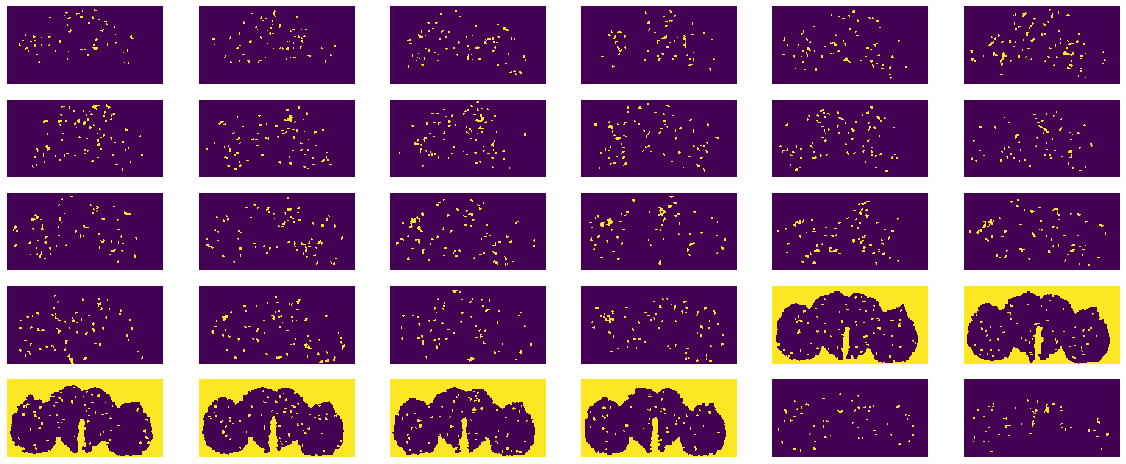

In [155]:
plt.figure(figsize=(20,10))
for i,z in enumerate(range(10,40)):
    plt.subplot(6,6,i+1)
    plt.imshow(slices[i].T)
    plt.axis('off')

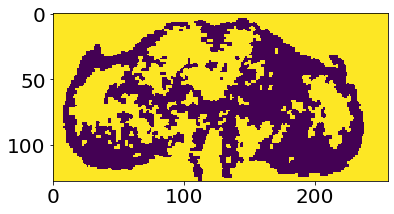

In [131]:
plt.imshow(empty.T)

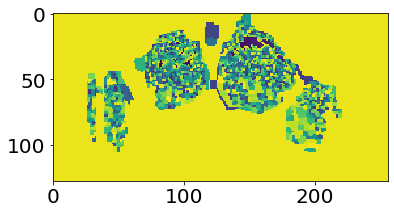

In [67]:
z = 3
labels_2d = np.reshape(cluster_model_labels,(49,256,128))

empty = np.zeros((256,128))
for i in range(2000):
    idx = np.where(labels_2d[z,:,:]==i)
    empty[idx[0],idx[1]]=i
plt.imshow(empty.T,)